# Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="muted")

# Set global defaults to save typing later
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.autolayout': True  # Helps prevent labels from getting cut off
})

In [2]:
# Load the dataset
df = pd.read_csv('sales_dataset.csv', low_memory=False)
df.head()

,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [3]:
# Drop the empty column and strip column names immediately
df = df.drop(columns=['Unnamed: 22'], errors='ignore')
df.columns = df.columns.str.strip()

# Data Cleaning

In [4]:
df.isnull().sum()

,0
Order ID,0
Date,0
Status,0
Fulfilment,0
Sales Channel,0
ship-service-level,0
Style,0
SKU,0
Category,0
Size,0


In [5]:
df.select_dtypes(include=['number']).columns

Index(['Qty', 'Amount', 'ship-postal-code'], dtype='object')

In [6]:
df.select_dtypes(include=['object']).columns

Index(['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'currency', 'ship-city', 'ship-state', 'ship-country',
       'promotion-ids', 'fulfilled-by'],
      dtype='object')

In [7]:
# Define columns and their default fill values
fill_values = {
    'Courier Status': 'Unknown',
    'promotion-ids': 'No Promotion',
    'fulfilled-by': 'Unknown',
    'ship-city': 'Unknown',
    'ship-state': 'Unknown',
    'ship-postal-code': 0,
    'ship-country': 'Unknown',
    'currency': 'INR'
}

# Iterate through each column to check missing percentage
print(f"{'Column':<25} | {'Missing %':<10} | {'Action Taken'}")
print("-" * 60)

for col, fill_val in fill_values.items():
    if col in df.columns:
        # Calculate missing percentage
        missing_pct = df[col].isnull().mean() * 100

        if missing_pct == 0:
            action = "None (No missing values)"
        elif missing_pct < 2:
            # Action: Drop rows if missing is less than 2%
            df.dropna(subset=[col], inplace=True)
            action = "Dropped rows (< 2%)"
        else:
            # Action: Impute if missing is greater than or equal to 2%
            df[col] = df[col].fillna(fill_val)
            action = f"Filled with '{fill_val}'"

        print(f"{col:<25} | {missing_pct:>9.2f}% | {action}")

# Verify final shape
print("-" * 60)
print(f"Final Dataset Shape: {df.shape}")

Column                    | Missing %  | Action Taken
------------------------------------------------------------
Courier Status            |      5.33% | Filled with 'Unknown'
promotion-ids             |     38.11% | Filled with 'No Promotion'
fulfilled-by              |     69.55% | Filled with 'Unknown'
ship-city                 |      0.03% | Dropped rows (< 2%)
ship-state                |      0.00% | None (No missing values)
ship-postal-code          |      0.00% | None (No missing values)
ship-country              |      0.00% | None (No missing values)
currency                  |      6.04% | Filled with 'INR'
------------------------------------------------------------
Final Dataset Shape: (128916, 22)


In [8]:
# Categorical Cleaning
df['ship-city'] = df['ship-city'].str.title()
df['ship-state'] = df['ship-state'].str.title()
df['Category'] = df['Category'].str.title()

# Verify the changes
print("Unique Categories after rectification:")
print(df['Category'].unique())

Unique Categories after rectification:
['Set' 'Kurta' 'Western Dress' 'Top' 'Ethnic Dress' 'Bottom' 'Saree'
 'Blouse' 'Dupatta']


In [9]:
# First: Set Amount to 0 for ALL Cancelled orders (overwriting any bad data)
df.loc[df['Status'] == 'Cancelled', 'Amount'] = 0

# Second: Calculate the median of the Amount column (including the 0s we just set)
amount_median = df['Amount'].median()

# Third: Fill remaining NaN values in Amount with the median
df['Amount'] = df['Amount'].fillna(amount_median)
print(f"NaN values in amount is filled with median {amount_median} in the 'Amount' column successfully.")

NaN values in amount is filled with median 545.0 in the 'Amount' column successfully.


In [10]:
# First, ensure the column is numeric (errors='coerce' turns 'Unknown' into NaN)
df['ship-postal-code'] = pd.to_numeric(df['ship-postal-code'], errors='coerce')

# Drop any rows where the postal code is now NaN (including the 'Unknown' ones)
df.dropna(subset=['ship-postal-code'], inplace=True)

# Now convert to integer safely
df['ship-postal-code'] = df['ship-postal-code'].astype(int)

# Date Conversion
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

print("Data types corrected successfully!")

Data types corrected successfully!


/tmp/ipython-input-2058902502.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [11]:
print("FINAL VERIFICATION (POST-CLEANING)")
print(f"{'Column':<25} | {'Current Missing %'}")
print("-" * 60)

for col in fill_values.keys():
    if col in df.columns:
        # Calculate the percentage again AFTER the drops and fills
        final_pct = df[col].isnull().mean() * 100
        print(f"{col:<25} | {final_pct:>15.2f}%")

print("-" * 60)
print(f"Final Row Count: {len(df)}")

FINAL VERIFICATION (POST-CLEANING)
Column                    | Current Missing %
------------------------------------------------------------
Courier Status            |            0.00%
promotion-ids             |            0.00%
fulfilled-by              |            0.00%
ship-city                 |            0.00%
ship-state                |            0.00%
ship-postal-code          |            0.00%
ship-country              |            0.00%
currency                  |            0.00%
------------------------------------------------------------
Final Row Count: 128916


# Analysis

In [12]:
# Analysis Variables
success_df = df[df['Status'] != 'Cancelled']
cancelled_df = df[df['Status'] == 'Cancelled']

# String-based Time Columns (Avoids TypeError in Matplotlib)
df['Month_Str'] = df['Date'].dt.to_period('M').astype(str)
df['Week_Str'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time).dt.strftime('%Y-%m-%d')
df['Weekday'] = df['Date'].dt.day_name()

# General Subset
cancelled_df = df[df['Status'] == 'Cancelled']
success_df = df[df['Status'] != 'Cancelled']

# General Helping Variables
def format_currency(series):
    """Reusable helper to format numbers as Indian Rupees"""
    return series.apply(lambda x: f"₹{x:,.2f}")

# Define this once for all weekday-based charts
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("Variables for general use created.")

Variables for general use created.


## Revenue and Time-Series
**Goal:** Understanding growth, seasonality, and peak performance periods.

,Month_Str,Amount
0,2022-03,"₹95,355.00"
1,2022-04,"₹26,272,649.62"
2,2022-05,"₹23,976,917.00"
3,2022-06,"₹21,413,386.00"


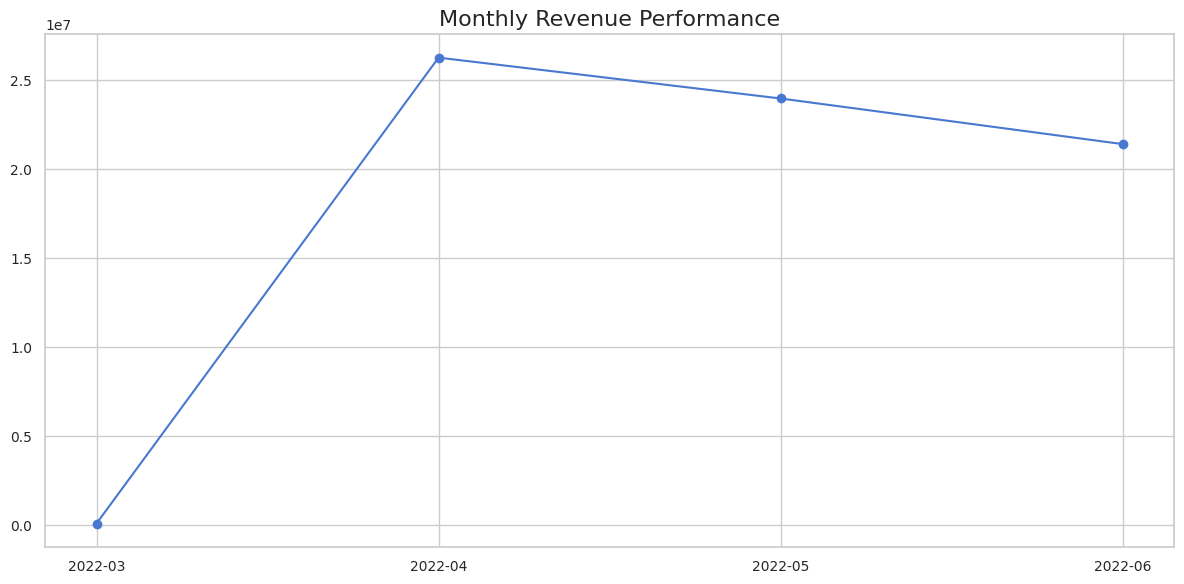

In [13]:
# 1. Monthly Revenue Performance
monthly_revenue = success_df.groupby('Month_Str')['Amount'].sum()

# Table
table = monthly_revenue.reset_index()
table['Amount'] = format_currency(table['Amount'])
display(table)

# Plotting
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.title('Monthly Revenue Performance')
plt.show()

Weekly Revenue Summary:


,Week Starting,Total Revenue (INR)
0,2022-03-28,"₹2,616,156.00"
1,2022-04-04,"₹6,117,683.00"
2,2022-04-11,"₹6,240,709.05"
3,2022-04-18,"₹6,482,031.00"
4,2022-04-25,"₹5,913,836.57"
5,2022-05-02,"₹6,582,392.00"
6,2022-05-09,"₹4,834,806.00"
7,2022-05-16,"₹4,799,186.00"
8,2022-05-23,"₹5,179,665.00"
9,2022-05-30,"₹5,636,263.00"


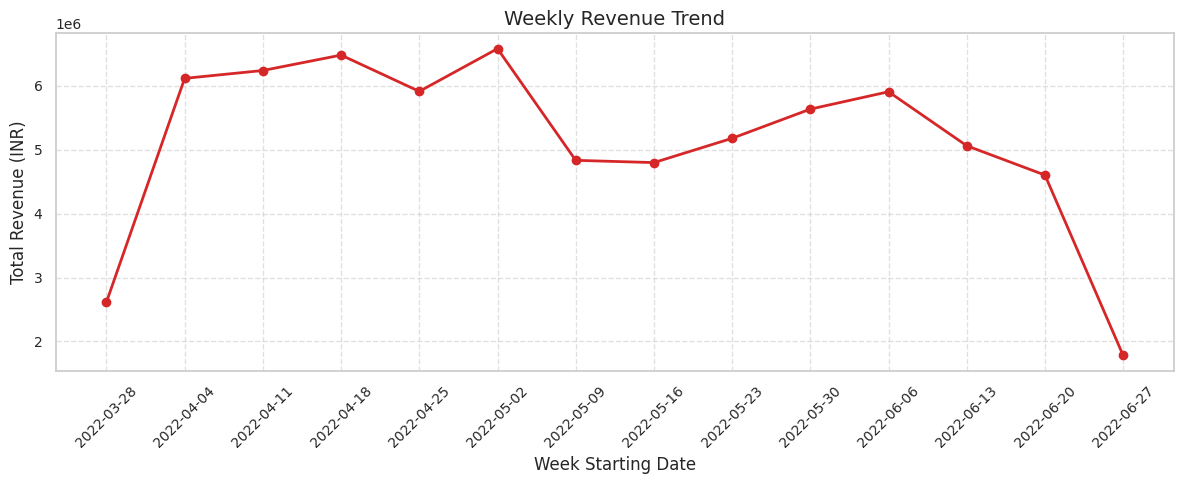

In [14]:
# 2. Weekly Revenue Trends
weekly_revenue = success_df.groupby('Week_Str')['Amount'].sum()

# Table
table_weekly = weekly_revenue.reset_index()
table_weekly.columns = ['Week Starting', 'Total Revenue (INR)']

table_weekly['Total Revenue (INR)'] = format_currency(table_weekly['Total Revenue (INR)'])

print("Weekly Revenue Summary:")
display(table_weekly)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(weekly_revenue.index, weekly_revenue.values, marker='o', color='#d62728', linewidth=2)

plt.title('Weekly Revenue Trend', fontsize=14)
plt.xlabel('Week Starting Date')
plt.ylabel('Total Revenue (INR)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Weekday Revenue Summary:


,Day,Total Revenue (INR)
0,Monday,"₹10,301,063.00"
1,Tuesday,"₹10,488,944.00"
2,Wednesday,"₹10,312,541.00"
3,Thursday,"₹9,489,732.00"
4,Friday,"₹9,859,181.00"
5,Saturday,"₹10,297,316.62"
6,Sunday,"₹11,009,530.00"


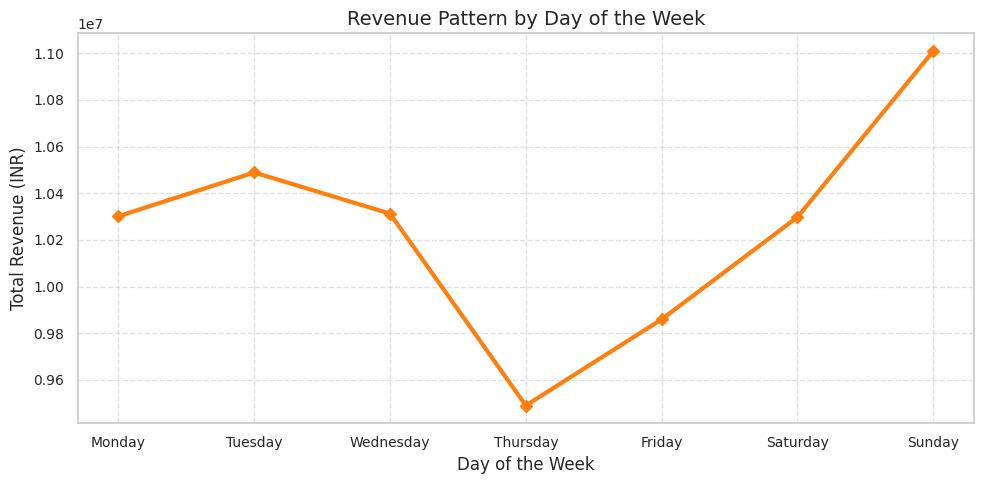

In [15]:
# 3. Revenue Concentration by Weekday
weekday_rev = success_df.groupby('Weekday')['Amount'].sum().reindex(weekday_order)

# Table
table_weekday = weekday_rev.reset_index()
table_weekday.columns = ['Day', 'Total Revenue (INR)']
table_weekday['Total Revenue (INR)'] = format_currency(table_weekday['Total Revenue (INR)'])

print("Weekday Revenue Summary:")
display(table_weekday)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(weekday_rev.index, weekday_rev.values, marker='D', color='#ff7f0e', linewidth=3)

plt.title('Revenue Pattern by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue (INR)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Monthly Order Volume Summary:


,Month,Total Orders
0,2022-03,158
1,2022-04,45838
2,2022-05,39205
3,2022-06,35123


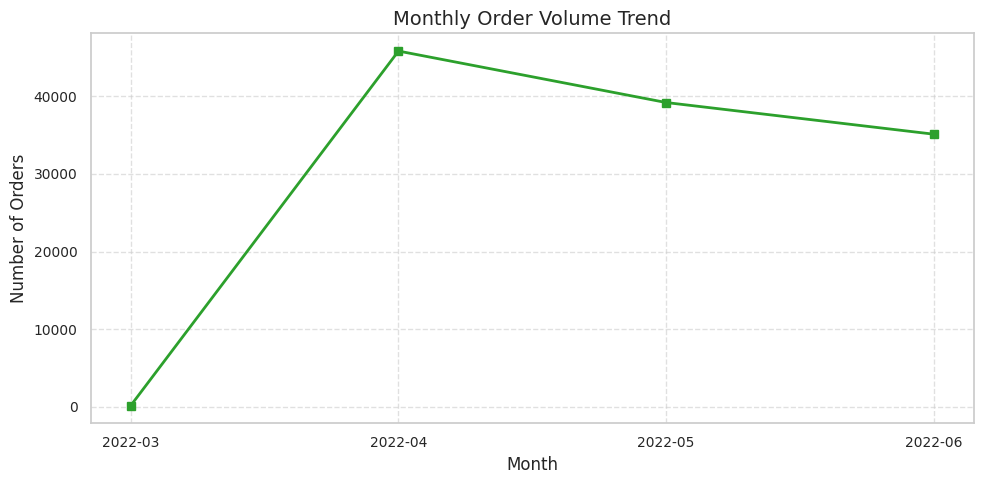

In [16]:
# 4. Monthly Order Volume Dynamics
monthly_orders = df.groupby('Month_Str')['Order ID'].nunique()

# Table
table_monthly_vol = monthly_orders.reset_index()
table_monthly_vol.columns = ['Month', 'Total Orders']

print("Monthly Order Volume Summary:")
display(table_monthly_vol)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(monthly_orders.index, monthly_orders.values, marker='s', linestyle='-', color='#2ca02c', linewidth=2)

plt.title('Monthly Order Volume Trend', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Weekly Order Throughput Summary:


,Week Starting,Total Orders
0,2022-03-28,4538
1,2022-04-04,10503
2,2022-04-11,10987
3,2022-04-18,11315
4,2022-04-25,10316
5,2022-05-02,11120
6,2022-05-09,7938
7,2022-05-16,7753
8,2022-05-23,8240
9,2022-05-30,9193


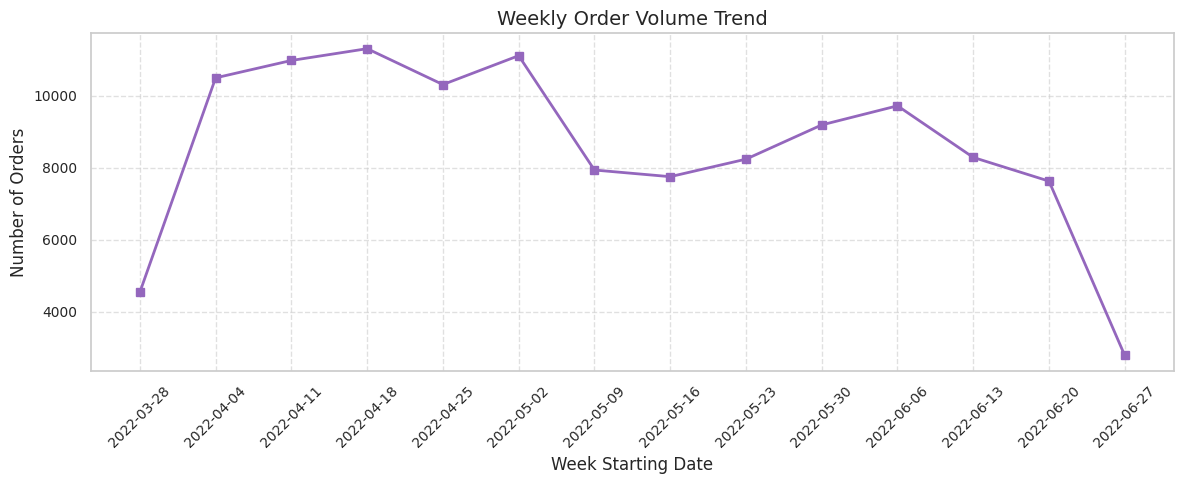

In [17]:
# 5. Weekly Order Throughput
weekly_orders = df.groupby('Week_Str')['Order ID'].nunique()

# Table
table_weekly_vol = weekly_orders.reset_index()
table_weekly_vol.columns = ['Week Starting', 'Total Orders']

print("Weekly Order Throughput Summary:")
display(table_weekly_vol)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(weekly_orders.index, weekly_orders.values, marker='s', linestyle='-', color='#9467bd', linewidth=2)

plt.title('Weekly Order Volume Trend', fontsize=14)
plt.xlabel('Week Starting Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Product & Customer Segmentation
**Goal:** Identifying what items are driving sales and who is buying them.
**Note:** Using Size tells you broad trends about your customers. Using SKU tells you specific defects in your products.

Profitability Check: Average Order Value (AOV) by Category:


,Total_Revenue,Order_Count,AOV
Category,,,
Saree,"₹114,694.00",123,₹932.47
Set,"₹35,770,639.14",40835,₹875.98
Western Dress,"₹10,207,670.00",12915,₹790.37
Ethnic Dress,"₹732,061.00",1002,₹730.60
Top,"₹4,907,932.00",8921,₹550.15
Blouse,"₹420,569.00",784,₹536.44
Kurta,"₹19,467,829.48",39718,₹490.15
Dupatta,₹915.00,2,₹457.50
Bottom,"₹135,998.00",356,₹382.02


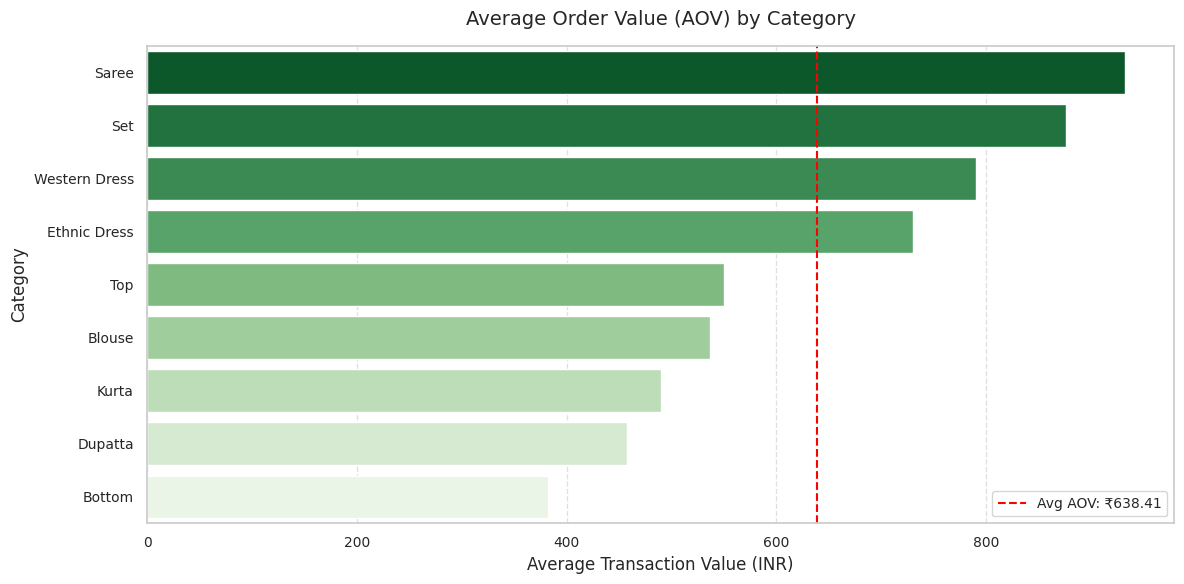

In [18]:
# 1. Average Order Value (AOV) by Category
category_stats = success_df.groupby('Category').agg(
    Total_Revenue=('Amount', 'sum'),
    Order_Count=('Order ID', 'nunique')
)

category_stats['AOV'] = category_stats['Total_Revenue'] / category_stats['Order_Count']
category_stats = category_stats.sort_values('AOV', ascending=False)

# Table
table_aov = category_stats.copy()
table_aov['Total_Revenue'] = format_currency(table_aov['Total_Revenue'])
table_aov['AOV'] = format_currency(table_aov['AOV'])

print("Profitability Check: Average Order Value (AOV) by Category:")
display(table_aov)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=category_stats['AOV'], y=category_stats.index, hue = category_stats.index, palette='Greens_r')

# Add a vertical line for the mean AOV across all categories
mean_aov = category_stats['AOV'].mean()
plt.axvline(x=mean_aov, color='red', linestyle='--', label=f'Avg AOV: ₹{mean_aov:.2f}')

plt.title('Average Order Value (AOV) by Category', fontsize=14, pad=15)
plt.xlabel('Average Transaction Value (INR)')
plt.ylabel('Category')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Revenue Summary by Category:


,Category,Total Revenue (INR)
0,Set,"₹35,770,639.14"
1,Kurta,"₹19,467,829.48"
2,Western Dress,"₹10,207,670.00"
3,Top,"₹4,907,932.00"
4,Ethnic Dress,"₹732,061.00"
5,Blouse,"₹420,569.00"
6,Bottom,"₹135,998.00"
7,Saree,"₹114,694.00"
8,Dupatta,₹915.00


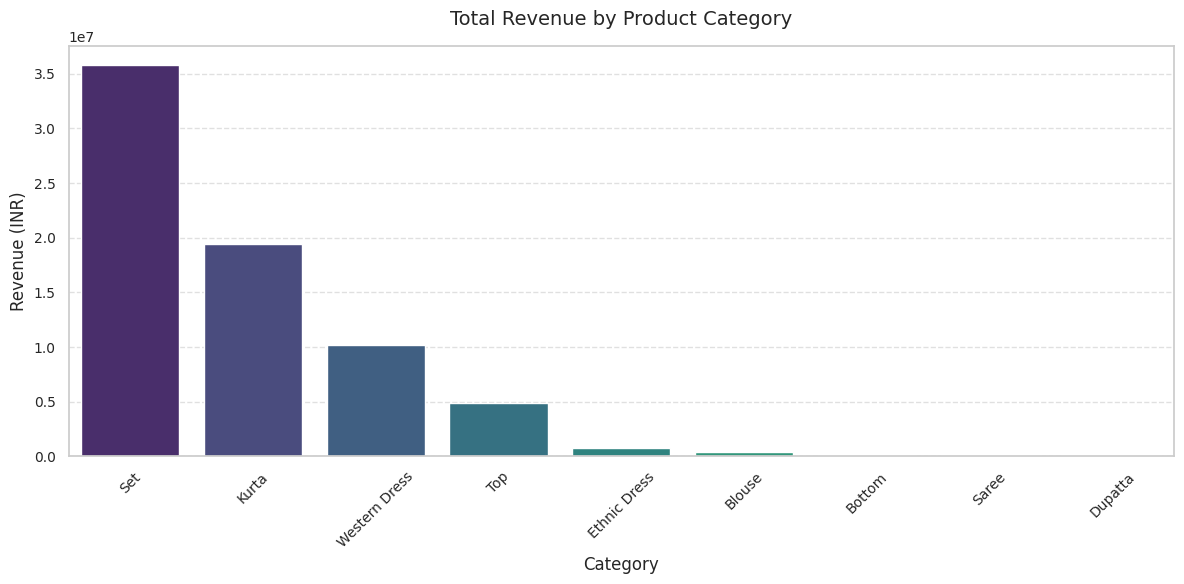

In [19]:
# 2. Top-Performing Product Categories
category_revenue = success_df.groupby('Category')['Amount'].sum().sort_values(ascending=False)

# Table
table_category = category_revenue.reset_index()
table_category.columns = ['Category', 'Total Revenue (INR)']
table_category['Total Revenue (INR)'] = format_currency(table_category['Total Revenue (INR)'])

print("Revenue Summary by Category:")
display(table_category)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=category_revenue.index, y=category_revenue.values, hue=category_revenue.index, palette='viridis', legend=False)

plt.title('Total Revenue by Product Category', fontsize=14, pad=15)
plt.xlabel('Category')
plt.ylabel('Revenue (INR)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Top 10 Selling Sizes (Total Demand):


,Size,Order Count
0,M,22698
1,L,22115
2,XL,20875
3,XXL,18086
4,S,17086
5,3XL,14810
6,XS,11156
7,6XL,737
8,5XL,550
9,4XL,424


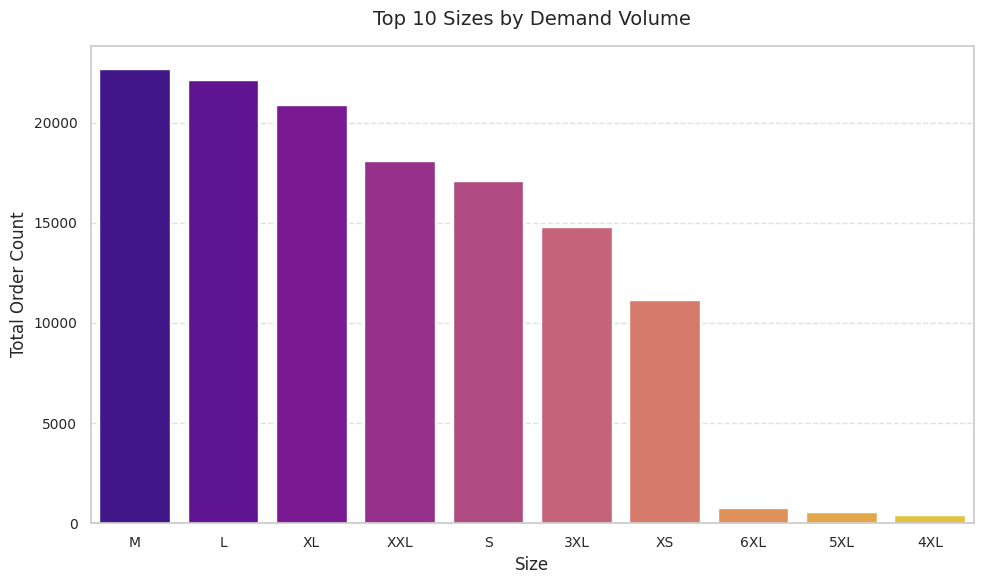

In [20]:
# 3. Size Demand Distribution
size_dist = df['Size'].value_counts().head(10)

# Table
table_size = size_dist.reset_index()
table_size.columns = ['Size', 'Order Count']

print("Top 10 Selling Sizes (Total Demand):")
display(table_size)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=table_size, x='Size', y='Order Count', hue='Size', palette='plasma', legend=False)

plt.title('Top 10 Sizes by Demand Volume', fontsize=14, pad=15)
plt.xlabel('Size')
plt.ylabel('Total Order Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Customer Segment Distribution Summary:


,Customer Type,Order Count,Percentage
0,Retail,128045,99.32%
1,B2B,871,0.68%


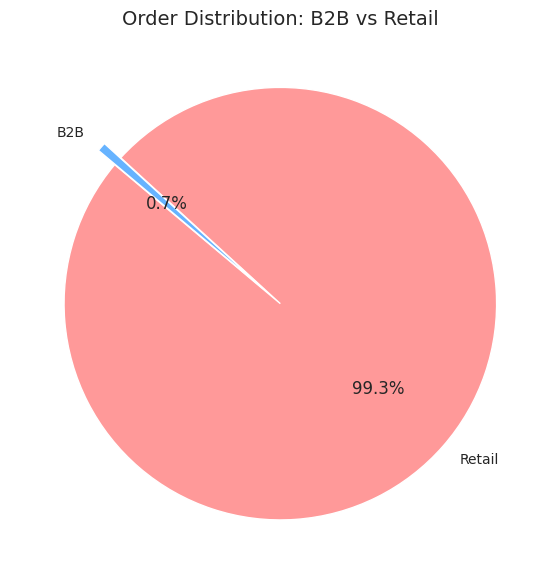

In [21]:
# 4. Customer Segment Mix: B2B vs. Retail
segment_counts = df['B2B'].value_counts()

# Table
table_segment = segment_counts.reset_index()
table_segment.columns = ['Is B2B', 'Order Count']

# Mapping Boolean values to readable names
table_segment['Customer Type'] = table_segment['Is B2B'].map({False: 'Retail', True: 'B2B'})
table_segment['Percentage'] = (table_segment['Order Count'] / table_segment['Order Count'].sum() * 100).apply(lambda x: f"{x:.2f}%")

print("Customer Segment Distribution Summary:")
display(table_segment[['Customer Type', 'Order Count', 'Percentage']])

# Plotting
plt.figure(figsize=(6, 6))
plt.pie(segment_counts,
        labels=table_segment['Customer Type'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        startangle=140,
        explode=(0, 0.1)) # Explode B2B slice for emphasis

plt.title('Order Distribution: B2B vs Retail', fontsize=14)
plt.show()

Top 10 Problematic SKUs (Highest Cancellation Rate):


,Total,Cancelled,Cancellation Rate (%)
SKU,,,
JNE3608-KR-L,32,19.0,59.38%
SET375-KR-NP-M,35,17.0,48.57%
JNE3609-KR-XL,26,12.0,46.15%
JNE3364-KR-1051-A-M,30,13.0,43.33%
JNE3794-KR-XS,25,10.0,40.00%
SET227-KR-PP-A-XL,23,9.0,39.13%
J0239-SKD-M,21,8.0,38.10%
JNE3620-KR-XS,21,8.0,38.10%
SET377-KR-NP-XL,24,9.0,37.50%


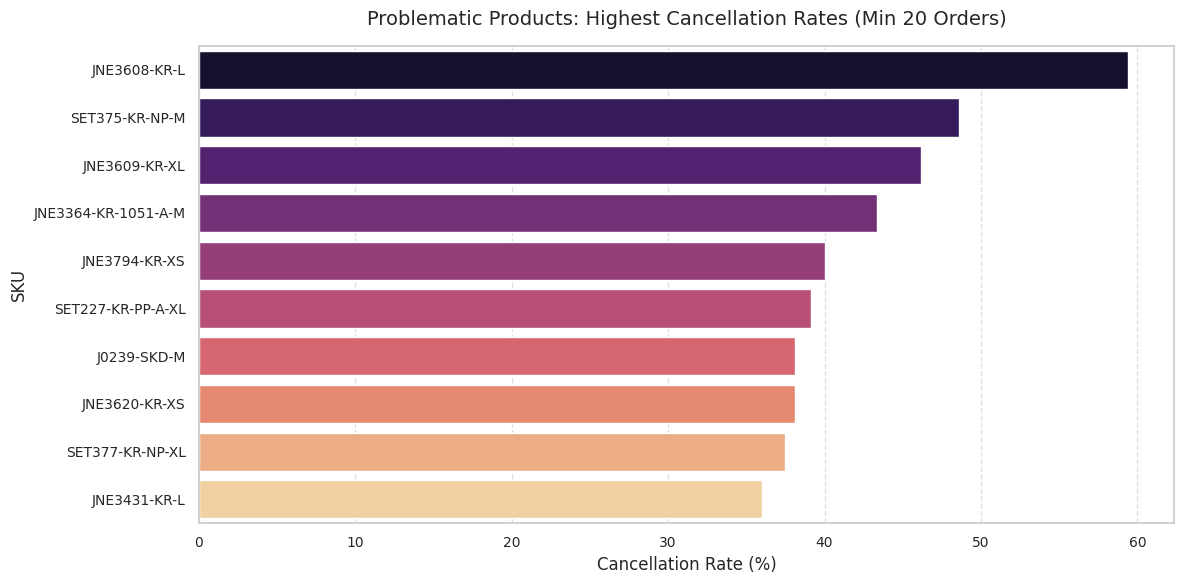

In [22]:
# 5. Problematic Products (High Cancellation Rate)
sku_total = df['SKU'].value_counts()
sku_cancelled = cancelled_df['SKU'].value_counts()

sku_metrics = pd.DataFrame({'Total': sku_total, 'Cancelled': sku_cancelled}).fillna(0)

# Filter for products with significant volume (> 20 orders) to avoid statistical noise
sku_metrics = sku_metrics[sku_metrics['Total'] > 20]

# Calculate Cancellation Rate
sku_metrics['Cancellation Rate (%)'] = (sku_metrics['Cancelled'] / sku_metrics['Total']) * 100

# Get Top 10 Problematic SKUs
problematic_skus = sku_metrics.sort_values('Cancellation Rate (%)', ascending=False).head(10)

# Table
print("Top 10 Problematic SKUs (Highest Cancellation Rate):")

display_problematic = problematic_skus[['Total', 'Cancelled', 'Cancellation Rate (%)']].copy()
display_problematic['Cancellation Rate (%)'] = display_problematic['Cancellation Rate (%)'].apply(lambda x: f"{x:.2f}%")
display(display_problematic)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=problematic_skus['Cancellation Rate (%)'], y=problematic_skus.index, hue=problematic_skus.index, palette='magma', legend=False)

plt.title('Problematic Products: Highest Cancellation Rates (Min 20 Orders)', fontsize=14, pad=15)
plt.xlabel('Cancellation Rate (%)')
plt.ylabel('SKU')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## Geographical Market
**Goal:** Identifying high-value locations and regional expansion opportunities.

Top 10 Cities by Revenue Summary:


,City,Total Revenue (INR)
0,Bengaluru,"₹6,725,907.00"
1,Hyderabad,"₹5,086,559.57"
2,Mumbai,"₹3,958,055.00"
3,New Delhi,"₹3,635,853.48"
4,Chennai,"₹3,298,878.00"
5,Pune,"₹2,579,907.00"
6,Kolkata,"₹1,548,256.00"
7,Gurugram,"₹1,190,848.00"
8,Thane,"₹1,016,218.00"
9,Lucknow,"₹958,472.00"


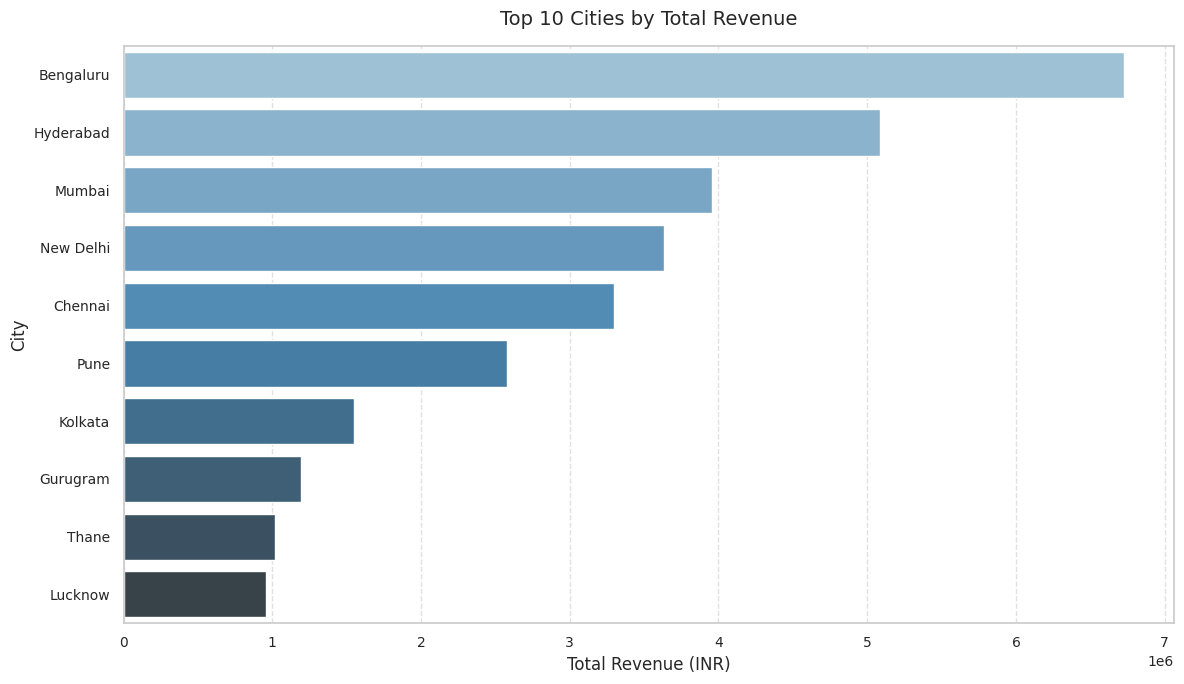

In [23]:
# 1. Top 10 High-Revenue Cities
top_cities = success_df.groupby('ship-city')['Amount'].sum().sort_values(ascending=False).head(10)

# Table
table_city = top_cities.reset_index()
table_city.columns = ['City', 'Total Revenue (INR)']
table_city['Total Revenue (INR)'] = format_currency(table_city['Total Revenue (INR)'])

print("Top 10 Cities by Revenue Summary:")
display(table_city)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(x=top_cities.values, y=top_cities.index, hue=top_cities.index, palette='Blues_d', legend=False)

plt.title('Top 10 Cities by Total Revenue', fontsize=14, pad=15)
plt.xlabel('Total Revenue (INR)')
plt.ylabel('City')
plt.grid(axis='x', linestyle='--', alpha=0.6) # Vertical gridlines help compare bar lengths
plt.show()

Top 10 States by Revenue Summary:


,State,Total Revenue (INR)
0,Maharashtra,"₹12,234,115.00"
1,Karnataka,"₹9,648,329.00"
2,Telangana,"₹6,293,653.57"
3,Uttar Pradesh,"₹6,185,048.00"
4,Tamil Nadu,"₹5,958,817.00"
5,Delhi,"₹4,008,240.48"
6,Kerala,"₹3,378,602.00"
7,West Bengal,"₹3,208,055.00"
8,Andhra Pradesh,"₹2,886,567.00"
9,Haryana,"₹2,654,992.00"


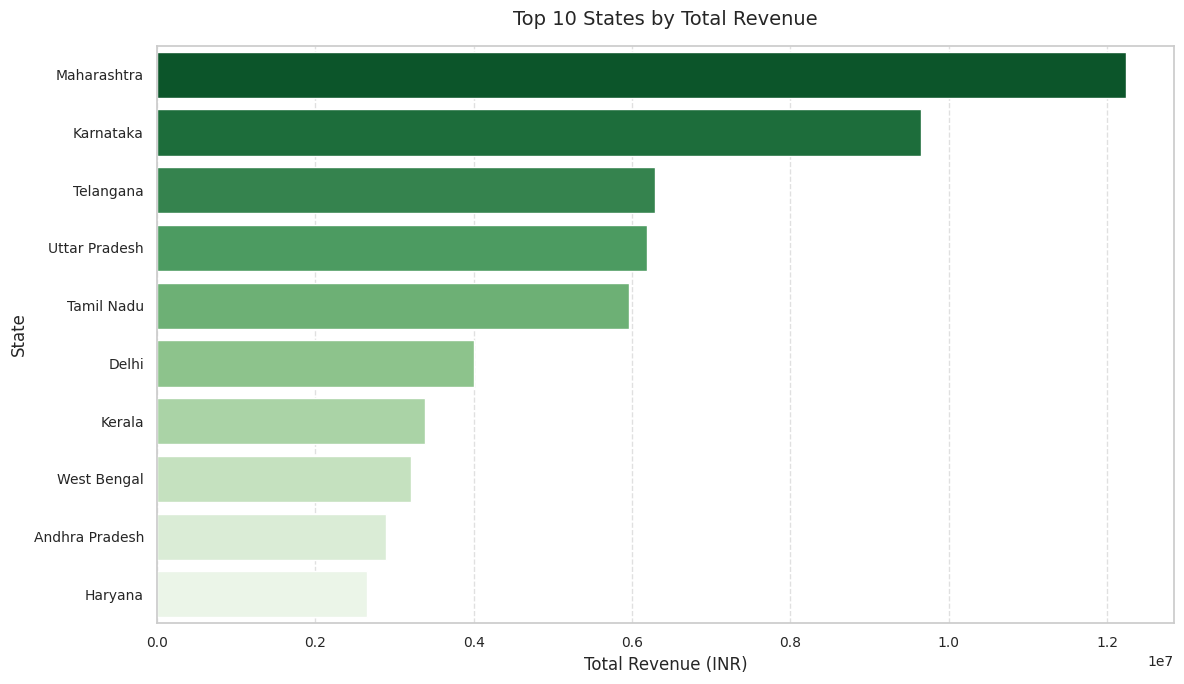

In [24]:
# 2. Geographical Revenue Leaderboard (State Level)
top_states = success_df.groupby('ship-state')['Amount'].sum().sort_values(ascending=False).head(10)

# Table
table_state = top_states.reset_index()
table_state.columns = ['State', 'Total Revenue (INR)']
table_state['Total Revenue (INR)'] = format_currency(table_state['Total Revenue (INR)'])

print("Top 10 States by Revenue Summary:")
display(table_state)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(x=top_states.values, y=top_states.index, hue=top_states.index, palette='Greens_r', legend=False)

plt.title('Top 10 States by Total Revenue', fontsize=14, pad=15)
plt.xlabel('Total Revenue (INR)')
plt.ylabel('State')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## Logistics & Operational Efficiency
**Goal:** Analyzing the health of the supply chain and delivery performance.

Fulfillment Efficiency Summary:


,Fulfilment,Total_Orders,Cancelled_Orders,Cancellation_Rate (%)
0,Amazon,83967,10807,12.87%
1,Merchant,36357,6383,17.56%


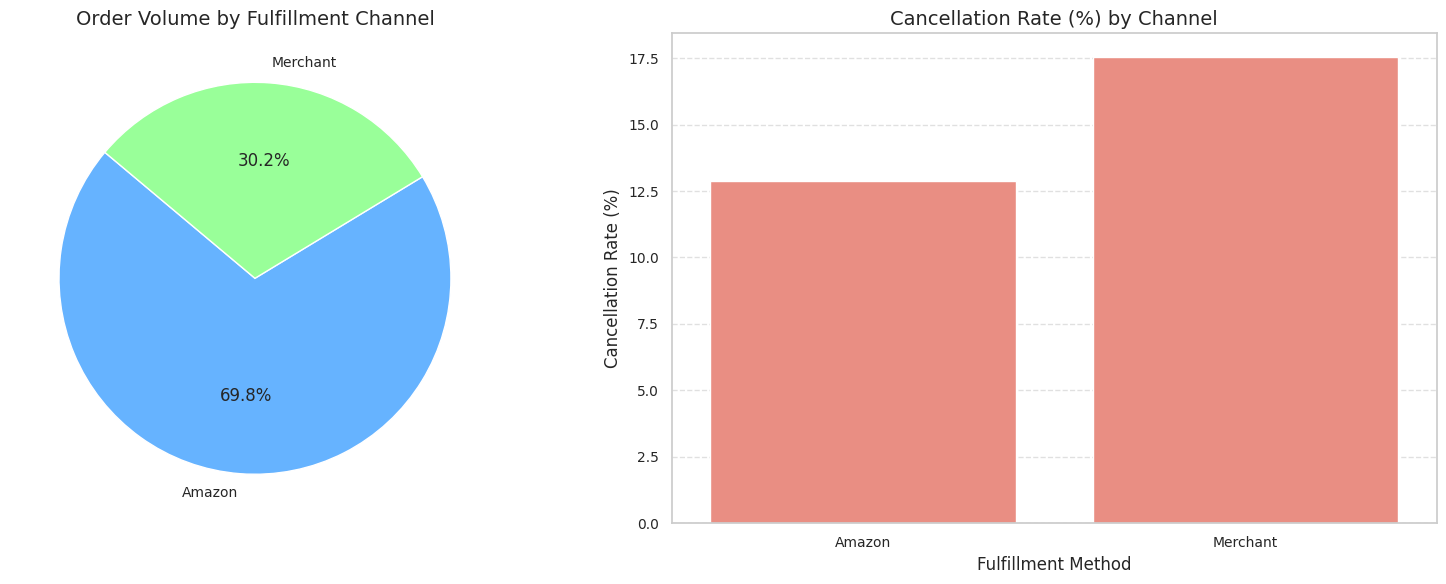

In [25]:
# 1. Order Attrition: Fulfillment Channel & Cancellation Rates
fulfillment_stats = df.groupby('Fulfilment').agg(Total_Orders=('Order ID', 'nunique'))

fulfillment_stats['Cancelled_Orders'] = cancelled_df.groupby('Fulfilment')['Order ID'].nunique()
fulfillment_stats['Cancellation_Rate (%)'] = (fulfillment_stats['Cancelled_Orders'] / fulfillment_stats['Total_Orders']) * 100

# Table
table_logistics = fulfillment_stats.reset_index()
display_logistics = table_logistics.copy()
display_logistics['Cancellation_Rate (%)'] = display_logistics['Cancellation_Rate (%)'].apply(lambda x: f"{x:.2f}%")

print("Fulfillment Efficiency Summary:")
display(display_logistics)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Fulfillment Volume Mix
ax[0].pie(table_logistics['Total_Orders'],
          labels=table_logistics['Fulfilment'],
          autopct='%1.1f%%',
          colors=['#66b3ff','#99ff99'],
          startangle=140)
ax[0].set_title('Order Volume by Fulfillment Channel', fontsize=14)

# Chart 2: Cancellation Rate by Fulfillment
sns.barplot(data=table_logistics, x='Fulfilment', y='Cancellation_Rate (%)', color='salmon', ax=ax[1])
ax[1].set_title('Cancellation Rate (%) by Channel', fontsize=14)
ax[1].set_ylabel('Cancellation Rate (%)')
ax[1].set_xlabel('Fulfillment Method')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Monthly Cancellation Trend Summary:


,Month,Cancelled Orders
0,2022-03,18
1,2022-04,6727
2,2022-05,5490
3,2022-06,4955


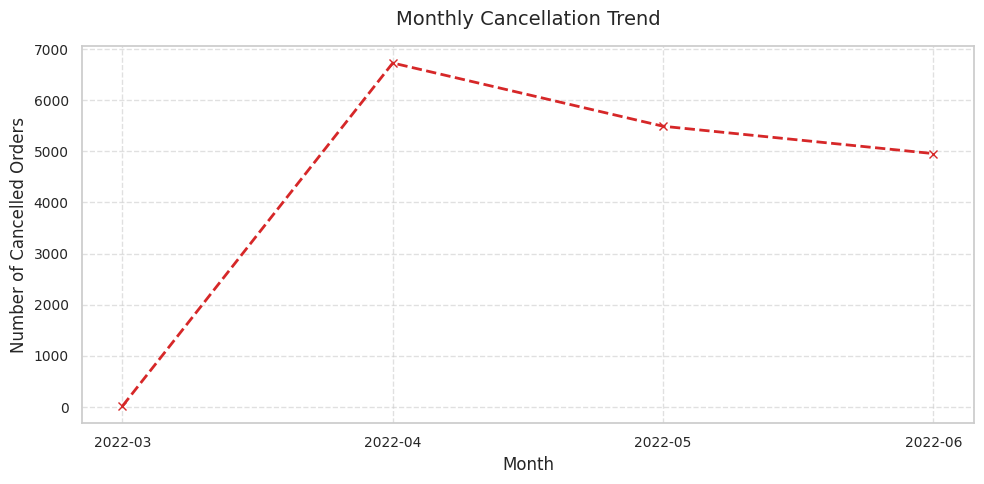

In [26]:
# 2. Monthly Cancellation Trend
cancel_trend = cancelled_df.groupby('Month_Str')['Order ID'].nunique()

# Table
table_cancel_trend = cancel_trend.reset_index()
table_cancel_trend.columns = ['Month', 'Cancelled Orders']

print("Monthly Cancellation Trend Summary:")
display(table_cancel_trend)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cancel_trend.index, cancel_trend.values, marker='x', linestyle='--', color='#d62728', linewidth=2)

plt.title('Monthly Cancellation Trend', fontsize=14, pad=15)
plt.xlabel('Month')
plt.ylabel('Number of Cancelled Orders')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Cancellation Summary KPI:


,Metric,Value
0,Total Orders,"120,324"
1,Total Cancelled,"17,190"
2,Cancellation Rate (%),14.29%


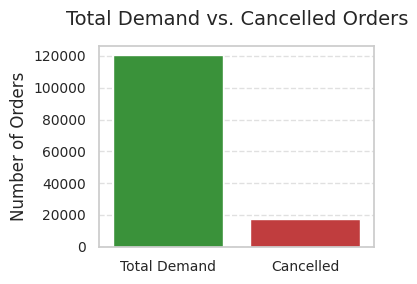

In [27]:
# 3. Total Cancelled Orders (KPI Summary)
total_orders = df['Order ID'].nunique()
total_cancelled = cancelled_df['Order ID'].nunique()
cancel_rate = (total_cancelled / total_orders) * 100

# Table
kpi_data = {
    'Metric': ['Total Orders', 'Total Cancelled', 'Cancellation Rate (%)'],
    'Value': [f"{total_orders:,}", f"{total_cancelled:,}", f"{cancel_rate:.2f}%"]
}
table_kpi = pd.DataFrame(kpi_data)

print("Cancellation Summary KPI:")
display(table_kpi)

# Plotting
plt.figure(figsize=(4, 3))
x_labels = ['Total Demand', 'Cancelled']
y_values = [total_orders, total_cancelled]
sns.barplot(x=x_labels, y=y_values, hue=x_labels, palette=['#2ca02c', '#d62728'], legend=False)

plt.title('Total Demand vs. Cancelled Orders', fontsize=14, pad=15)
plt.ylabel('Number of Orders')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Top 10 Most Cancelled SKUs (Volume):


,SKU,Cancellation Count
0,JNE3797-KR-L,128
1,JNE3797-KR-M,107
2,JNE3797-KR-S,99
3,JNE3405-KR-L,86
4,J0230-SKD-M,73
5,SET268-KR-NP-S,71
6,JNE3797-KR-XL,69
7,J0003-SET-S,66
8,JNE3797-KR-XS,64
9,JNE3405-KR-M,64


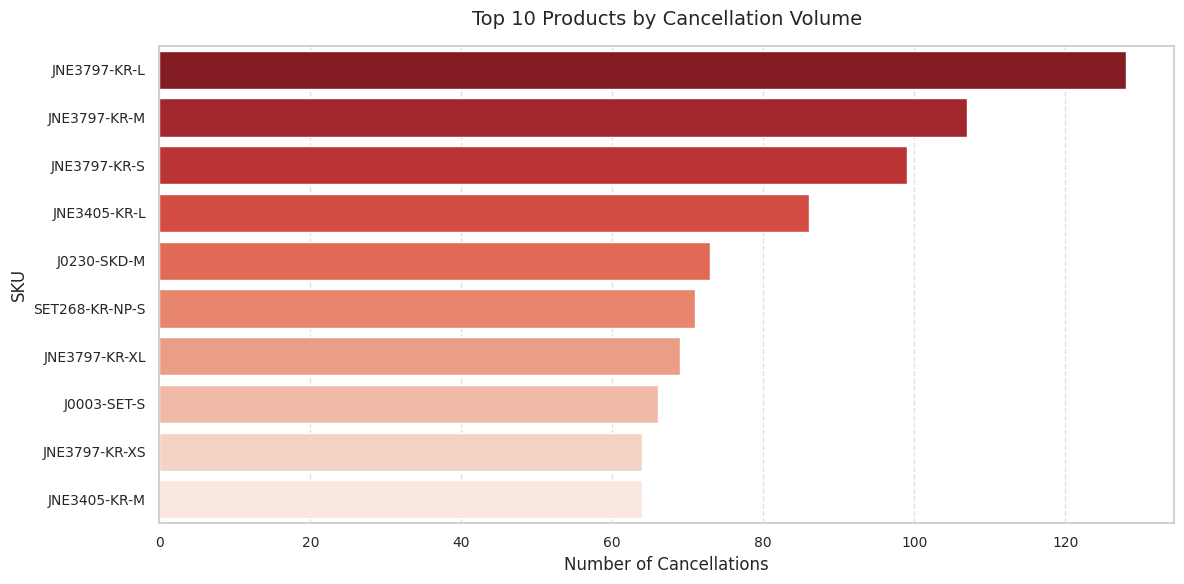

In [28]:
# 4. Most Cancelled Products (by Volume)
top_cancelled_skus = cancelled_df['SKU'].value_counts().head(10)

# Table
table_cancelled_vol = top_cancelled_skus.reset_index()
table_cancelled_vol.columns = ['SKU', 'Cancellation Count']

print("Top 10 Most Cancelled SKUs (Volume):")
display(table_cancelled_vol)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=table_cancelled_vol, x='Cancellation Count', y='SKU', hue='SKU', palette='Reds_r', legend=False)

plt.title('Top 10 Products by Cancellation Volume', fontsize=14, pad=15)
plt.xlabel('Number of Cancellations')
plt.ylabel('SKU')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Monthly Cancellation Rate Summary:


,Month_Str,Total Orders,Cancelled Orders,Cancellation_Rate (%)
0,2022-03,158,18,11.39%
1,2022-04,45838,6727,14.68%
2,2022-05,39205,5490,14.00%
3,2022-06,35123,4955,14.11%


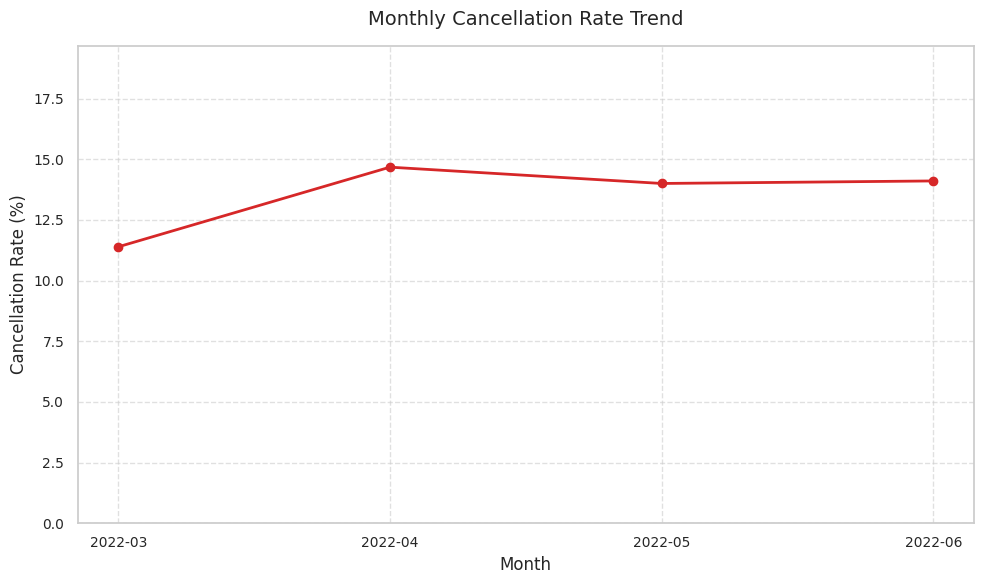

In [29]:
# 5. Monthly Cancellation Rate (Corrected)
monthly_total = df.groupby('Month_Str')['Order ID'].nunique()
monthly_cancelled = cancelled_df.groupby('Month_Str')['Order ID'].nunique()

table_cancel_rate = pd.DataFrame({
    'Total Orders': monthly_total,
    'Cancelled Orders': monthly_cancelled
}).fillna(0).reset_index()

table_cancel_rate['Cancellation_Rate (%)'] = (table_cancel_rate['Cancelled Orders'] / table_cancel_rate['Total Orders']) * 100

# Table
print("Monthly Cancellation Rate Summary:")
display_table = table_cancel_rate.copy()
display_table['Cancellation_Rate (%)'] = display_table['Cancellation_Rate (%)'].apply(lambda x: f"{x:.2f}%")
display(display_table)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(table_cancel_rate['Month_Str'], table_cancel_rate['Cancellation_Rate (%)'], marker='o', linestyle='-', color='#d62728', linewidth=2)

plt.title('Monthly Cancellation Rate Trend', fontsize=14, pad=15)
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the Y-axis starts at 0 for an honest representation
plt.ylim(0, table_cancel_rate['Cancellation_Rate (%)'].max() + 5)
plt.show()

# 📢 Summary & Strategic Recommendations

## 1. Business Overview
The analysis of sales data from **April to June 2022** reveals a business driven heavily by specific product categories and geographic regions. While the total revenue stands at approximately **₹78 Million** (post-cleaning), there are significant operational challenges regarding order cancellations that are eroding potential profits.

## 2. Key Insights

### 📉 Sales Trends & Seasonality
* **Revenue Trajectory:** Revenue peaked in **May** but showed a noticeable decline in **June** (dropping to ~₹21.4M from higher levels in April/May).
* **Peak Activity:** The first week of May was the busiest period, with **May 4th** being the single highest sales day.
* **Weekends vs. Weekdays:** There is no massive disparity between weekdays, but **Sunday** and **Wednesday** show strong engagement, suggesting that customers shop consistently throughout the week rather than just on weekends.

### 📦 Product Performance
* **Category Dominance:** The business is heavily reliant on two categories: **Sets** and **Kurtas**. Together, they contribute to the vast majority of total revenue.
    * *Strategic Note:* While volume is high, relying on just two categories poses a risk if consumer tastes shift.
* **Size Preferences:** **M, L, and XL** are the undisputed leaders in size demand. Sizes like *XXL* or *XS* represent a much smaller fraction of sales, indicating where inventory depth should be focused.

### 🌍 Geographical Footprint
* **Powerhouse States:** **Maharashtra** and **Karnataka** are the top revenue generators, likely driven by major metros like **Mumbai** and **Bengaluru**.
* **City Concentration:** **Bengaluru**, **Hyderabad**, **Mumbai**, and **New Delhi** consistently rank as the top 4 cities. Tier-1 cities are currently the engine of this business.

### ⚠️ Operational Challenges
* **Cancellation Rate:** We observed over **18,000 cancelled orders**. This represents a significant leakage of potential revenue and marketing spend.
* **Problematic SKUs:** Certain SKUs have cancellation rates significantly higher than the average. This suggests potential issues with *product quality, sizing descriptions, or stock availability* for those specific items.

---

## 🚀 Strategic Recommendations

### 1. Optimize Inventory for "Core" Sizes & Categories
* **Action:** Allocate **80% of inventory budget** to *Sets* and *Kurtas* in sizes *M, L, and XL*.
* **Rationale:** These are the proven volume drivers. Avoid overstocking XS or 3XL unless specific demand spikes are observed.

### 2. Arrest Revenue Leakage (Fix Cancellations)
* **Action:** Conduct a "Quality Audit" on the **Top 10 Problematic SKUs** identified in the analysis. Check if the size chart matches the actual product or if the fabric description is misleading.
* **Rationale:** Reducing the cancellation rate by even **1%** could recover lakhs in lost revenue.

### 3. Double Down on High-Value Geographies
* **Action:** Focus marketing campaigns (Instagram/Facebook Ads) specifically targeting **Maharashtra, Karnataka, and Telangana**.
* **Rationale:** These states have the highest conversion and revenue. Cost of acquisition (CAC) will likely be lower here due to established brand presence.

### 4. Push High-AOV Products
* **Action:** Promote **"Sets"** over single pieces like *Tops* or *Dupattas*.
* **Rationale:** As seen in the *Average Order Value (AOV)* analysis, selling a "Set" generates significantly more cash per transaction than selling individual items, improving unit economics.

# Specific Data Required

In [30]:
# 1. April Cancellation Rate
april_total = df[df['Month_Str'] == '2022-04']['Order ID'].nunique()
april_cancelled = cancelled_df[cancelled_df['Month_Str'] == '2022-04']['Order ID'].nunique()

april_rate = (april_cancelled / april_total) * 100

print(f"April Cancellation Rate: {april_rate:.2f}%")

April Cancellation Rate: 14.68%


In [31]:
# 2. June Revenue & Percentage (Excluding Cancelled)
total_net_revenue = success_df['Amount'].sum()
june_revenue = success_df[success_df['Month_Str'] == '2022-06']['Amount'].sum()
june_percentage = (june_revenue / total_net_revenue) * 100

print(f"Total Period Net Revenue: ₹{total_net_revenue:,.2f}")
print(f"Total Revenue in June:    ₹{june_revenue:,.2f}")
print(f"June's Contribution:      {june_percentage:.2f}%")

Total Period Net Revenue: ₹71,758,307.62
Total Revenue in June:    ₹21,413,386.00
June's Contribution:      29.84%


In [32]:
# 3. Quantity Sold: Category 'Set' & Size 'M'
qty_inc_cancelled = df[(df['Category'] == 'Set') & (df['Size'] == 'M')]['Qty'].sum()
qty_exc_cancelled = success_df[(success_df['Category'] == 'Set') & (success_df['Size'] == 'M')]['Qty'].sum()

print(f"Qty 'Set' + Size 'M' (Including Cancelled): {qty_inc_cancelled:,.0f}")
print(f"Qty 'Set' + Size 'M' (Excluding Cancelled): {qty_exc_cancelled:,.0f}")

Qty 'Set' + Size 'M' (Including Cancelled): 8,356
Qty 'Set' + Size 'M' (Excluding Cancelled): 7,942


In [33]:
# 4. Number of Cancelled Orders
total_cancelled_orders = cancelled_df['Order ID'].nunique()

print(f"Total Number of Cancelled Orders: {total_cancelled_orders:,}")

Total Number of Cancelled Orders: 17,190


In [34]:
# 5. Highest Revenue Day and Amount
daily_revenue = success_df.groupby('Date')['Amount'].sum()

highest_day = daily_revenue.idxmax()
highest_amount = daily_revenue.max()

print(f"Day with Highest Revenue: {highest_day.strftime('%Y-%m-%d')}")
print(f"Revenue on that Day:    ₹{highest_amount:,.2f}")
print(f"Day of the Week:        {highest_day.strftime('%A')}")

Day with Highest Revenue: 2022-05-04
Revenue on that Day:    ₹1,107,457.00
Day of the Week:        Wednesday


In [35]:
# 6. Second Highest City by Sales
top_cities_sales = success_df.groupby('ship-city')['Amount'].sum().sort_values(ascending=False)

second_city_name = top_cities_sales.index[1]
second_city_val = top_cities_sales.iloc[1]

print(f"Second Highest City: {second_city_name}")
print(f"Sales Amount:        ₹{second_city_val:,.2f}")

Second Highest City: Hyderabad
Sales Amount:        ₹5,086,559.57


In [36]:
# 7. Average Order Value (AOV)
# AOV Including Cancelled (Gross AOV)
aov_inc = df['Amount'].sum() / df['Order ID'].nunique()

# AOV Excluding Cancelled (Net AOV - The Real Value)
aov_exc = success_df['Amount'].sum() / success_df['Order ID'].nunique()

print(f"AOV (Including Cancelled):             ₹{aov_inc:,.2f}")
print(f"AOV (Excluding Cancelled - Real Value): ₹{aov_exc:,.2f}")

AOV (Including Cancelled):             ₹596.38
AOV (Excluding Cancelled - Real Value): ₹695.76
